## MODEL DEVELOPMENT

In [1]:
# import all necessary packages 

# to connect W&B platform
import wandb  

# to handle dataframe 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# to split dataset
from sklearn.model_selection import train_test_split

# to train model
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn

### Main Purpose of CTR Prediction Model

The main purpose of CTR prediction is to enhance the performance of online advertising and content recommendation systems, leading to increased revenue, better user experiences, and more effective marketing strategies. Accurate CTR prediction allows organizations to optimize their digital interactions with users, resulting in tangible benefits for both businesses and consumers.

### Algorithms

Click-Through Rate (CTR) dataset includes only categorical features and a binary target indicating whether a click occurred (0 or 1), There are specific models that can work well for these kinds of datasets, such as; Logistic Regression, Field-Aware Factorization Machines, CatBoost, LightGBM, XGBoost, Deep learning models with embedding layers, etc. According to the research, the Catboost algorithm can be a more suitable algorithm than other algorithms for this purpose.


#### Catboost Algorithm
CatBoost is a supervised machine learning technique employed within the Train Using AutoML tool. It relies on decision trees for tasks involving classification and regression. The name CatBoost signifies its primary attributes: the ability to handle categorical data (represented by "Cat") and its utilization of gradient boosting (signified by "Boost"). 

Advantages;
* Handle categorical features without requiring one-hot encoding or other transformations.
* Automatically scales the gradient magnitudes of numerical features and the target variable.
* Includes built-in regularization to prevent overfitting. It includes embedded methods to avoid overfitting.
* Less preprocessing with no encoding and handling missing values. 
* Has both CPU and GPU implementations. The GPU implementation allows for much faster training and is faster than both state-of-the-art open-source implementations.

Because of the advantages above, Catboost was chosen for this study. CatBoost is a good choice, but the best model depends on your specific dataset and experiments. It's always a good idea to compare CatBoost's performance with other models like LightGBM, XGBoost, and Factorization Machines to find the optimal model for your task. 

CatBoost is based on gradient boosted decision trees. During training, a set of decision trees is built consecutively. Each successive tree is built with reduced loss compared to the previous trees. https://catboost.ai/en/docs/concepts/algorithm-main-stages

DON'T FORGET⚠ Cross-validation is an important technic to find best performed model, especially if you have a restricted number of data and need a more generalized model. CV will help you identify the most suitable model for your CTR prediction. In this notebook, CV is not applied, but the Catboost library also includes cv methods. (*from catboost import cv*)


Please check the Catboost paper: https://arxiv.org/pdf/1810.11363.pdf

Please check the documentation of Catboost: https://catboost.ai/en/docs/

In [2]:
# connect wandb with your key

# wandb.login(api_key="YOUR_API_KEY")

# wandb login e7af045db59ef2d253743f547f333040a785e5ce
# OR
# wandb.login(api_key="e7af045db59ef2d253743f547f333040a785e5ce")

### Preprocessing

For the Catboost algorithm no need to apply encoding techniques such as one-hot encoding, label encoding, or target encoding (encoding categorical variables for regression problems) as a preprocess. It is handled by the algorithm implicitly. 

But to prepare the dataset for the model training; 
* Datatypes of the loaded dataset will be indicated again,
* The features "id" and "hour" will be removed, because hour and day info are already extracted from the hour column,
* Target column "click" is removed from the feature dataset and X and y datasets are created,
* Train, validation, and test sets are prepared according to percentages; 80%, 10%, 10%.

#### Important Features Selection
You can remove uninformative or redundant categorical features by domain knowledge, and correlation techniques before training. But if you couldn't detect correlated columns in the dataset explicitly, don't worry, Catboost offers regularization parameters (L1, L2) that can help reduce the impact of less important features during training.

In [3]:
# give datatypes

dtype={'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(str),
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str),
    'hour_of_day': np.dtype(str),
    'day_of_week': np.dtype(str),
      }

In [4]:
# load dataset

df = pd.read_csv('/dataset/training-dataset-10000.csv',dtype=dtype,)

In [5]:
# check non-null columns and datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                10000 non-null  uint64
 1   click             10000 non-null  int64 
 2   hour              10000 non-null  object
 3   C1                10000 non-null  object
 4   banner_pos        10000 non-null  object
 5   site_id           10000 non-null  object
 6   site_domain       10000 non-null  object
 7   site_category     10000 non-null  object
 8   app_id            10000 non-null  object
 9   app_domain        10000 non-null  object
 10  app_category      10000 non-null  object
 11  device_id         10000 non-null  object
 12  device_ip         10000 non-null  object
 13  device_model      10000 non-null  object
 14  device_type       10000 non-null  object
 15  device_conn_type  10000 non-null  object
 16  C14               10000 non-null  object
 17  C15          

In [6]:
# drop unnecessary columns

df.drop(columns=["id", "hour"], inplace=True)

In [7]:
# create feature df (X) and target df (y)
# X: Features, y: Target

X=df.drop(['click'],axis=1)
y=df['click']
X

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,431b3174,...,15704,320,50,1722,0,35,-1,79,0,Tuesday
1,1005,0,3695113d,8a9459c0,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,e7ab261c,...,20366,320,50,2333,0,39,100103,157,0,Tuesday
2,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,d0aa00c7,...,20352,320,50,2333,0,39,-1,157,0,Tuesday
3,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ef85aaad,...,15705,320,50,1722,0,35,100084,79,0,Tuesday
4,1005,0,85f751fd,c4e18dd6,50e219e0,1779deee,2347f47a,f95efa07,a99f214a,ba92cd0f,...,20596,320,50,2161,0,35,-1,157,0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,8f642135,...,21611,320,50,2480,3,299,100111,61,23,Thursday
9996,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,d30e5a48,...,23161,320,50,2667,0,47,-1,221,23,Thursday
9997,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,9cf8ab70,...,23160,320,50,2667,0,47,-1,221,23,Thursday
9998,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,10dcdfb1,...,23723,320,50,2716,3,47,-1,23,23,Thursday


In [8]:
# split dataset for training

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 10% test, 10% valid


While the 80-10-10 split is common, it's not set in stone. For smaller datasets, you might want to allocate a larger portion to training. In some cases, you might even consider a 70-15-15 split or variations depending on your specific needs and constraints.

In [9]:
X_train

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
9254,1005,0,85f751fd,c4e18dd6,50e219e0,1cc958a2,2347f47a,f95efa07,a99f214a,2022a4c8,...,23804,320,50,2726,3,803,100148,229,5,Thursday
1561,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a4afe726,...,15702,320,50,1722,0,35,-1,79,10,Wednesday
1670,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,fe75d0c7,...,21769,320,50,2507,0,35,-1,157,11,Wednesday
6087,1005,0,93eaba74,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,26b8bb1b,...,17654,300,250,1994,2,39,-1,33,6,Monday
6669,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,ab39bdf7,...,19772,320,50,2227,0,935,-1,48,22,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1005,0,85f751fd,c4e18dd6,50e219e0,090d3a47,0654b444,0f2161f8,a99f214a,b4b35bee,...,17212,320,50,1887,3,39,100194,23,17,Sunday
5191,1005,1,178a7b89,b4598159,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,7ab43b94,...,19771,320,50,2227,0,679,100081,48,7,Sunday
5390,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0fa21480,...,15706,320,50,1722,0,35,-1,79,11,Sunday
860,1005,0,85f751fd,c4e18dd6,50e219e0,2d869bee,d9b5648e,0f2161f8,a99f214a,1ca2d148,...,20751,320,50,1895,0,681,100028,101,19,Tuesday


In [10]:
y_train

9254    0
1561    1
1670    0
6087    0
6669    0
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: click, Length: 8000, dtype: int64

### Model Development

In this section, the Catboost algorithm is used for the training process. This algorithm includes various parameters to tune in the model development process. Weight&Bias platform is used to log every iteration results in the model development. 

Weights & Biases (W&B) is a comprehensive platform designed to aid machine learning practitioners throughout the entire model development and experimentation process. For this study, it is used to fine tune with a range of hyperparameters, the Bayesian search method is used to find the best combination of the hyperparameters. W&B helps to see the performance metrics of each different model and helps to find the best model by comparing the important metrics. 

CatBoost's integration with Bayesian optimization can help you find good hyperparameter settings in fewer iterations compared to grid search or random search. It takes into account the information from previous iterations to guide the search towards areas that are likely to lead to better performance.

In [11]:
# create list to keep index of the features to put into the model

cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21,22]

#### Which parameters can be tuned?

In tuning CatBoost, there are six main hyperparameters to focus on:

* **Number of Trees (iterations)**: represents the number of iterations the algorithm takes to create a more accurate model that learns from the data.
* **Learning Rate (learning_rate)**: adjusts how much each decision tree contributes to maintain the model's overall balance and precision. A larger learning rate means each tree has a more significant impact on the model, speeding up the learning process.
* **Depth**: “height” of decision trees. If you put high numbers, it can cause overfitting.
* **Subsample (subsample)**: a technique used to randomly choose a fraction of the dataset when constructing each tree, which helps to reduce overfitting. It controls the fraction of the training data (rows) to be randomly sampled for each tree.
* **Random Subspace Method (rms)**: controls the fraction of features (columns) to be randomly selected for each tree in the ensemble.
* **Minimum Data in Leaf (min_data_in_leaf)**: determines the minimum number of samples needed to form a leaf during the tree-building process. This parameter plays a crucial role in controlling the complexity of the trees generated by the model. Larger values promote simpler trees, reducing the risk of overfitting but potentially causing underfitting. Conversely, smaller values encourage more complex trees, which can lead to overfitting.


Other parameters which are not tuned:

* **early_stopping_rounds**: determines when to stop training based on the validation loss. It specifies the number of consecutive rounds with no improvement in the validation loss before training is halted. This helps prevent overfitting and saves time. It is determined 10 for this case, you can be determined according to your resources and needs.
* **use_best_model**: when set to True, instructs CatBoost to use the best model found during training, which is determined by monitoring the validation loss. The best model is the one with the lowest validation loss. This ensures that the model used for predictions is the one that generalizes best to unseen data.
* **verbose**: is not an important parameter that determines how much information about the training progress and metrics is displayed in the console or log files.

In [12]:
# define the sweep configuration to tune hyperparameters

sweep_config = {
    "method": "bayes",
    
    'metric': {
      'name': 'average_train_loss',
      'goal': 'minimize'   
    },
    
    "metric": {
        "name": "average_valid_loss",
        "goal": "minimize"
    },
    "parameters": {
        "learning_rate": {"min": 0.001 , "max": 0.1},
        "depth": {"min": 1, "max": 10}, # depth of tree
        "iterations": {"min": 100, "max": 500}, # learning iteration
        "subsample": {"min": 0.05, "max": 1.0},  # subsample parameter
        "rsm": {"min": 0.05, "max": 1.0},        # feature sampling by level
        "min_data_in_leaf": {"min": 1, "max": 100}  # minimum data in leaf
    }
}

# create the sweep
sweep_id = wandb.sweep(sweep_config, project="ctr-prediction")

# define the train function
def train():
    # initialize wandb for the current run
    with wandb.init(config=wandb.config):
        # get hyperparameters from the wandb.config object that includes parameter values
        learning_rate = wandb.config.learning_rate
        depth = wandb.config.depth
        iterations = wandb.config.iterations
        subsample = wandb.config.subsample  
        rsm = wandb.config.rsm              
        min_data_in_leaf = wandb.config.min_data_in_leaf  

        # create CatBoost model with the current hyperparameters
        model = CatBoostClassifier(
            learning_rate=learning_rate,
            depth=depth,
            iterations=iterations,
            cat_features=cat_features,  # add your categorical feature indices here
            early_stopping_rounds=10,  # stop if the validation loss doesn't improve for 10 rounds
            use_best_model=True,  # enable early stopping using the best model
            subsample=subsample,   
            rsm=rsm,            
            min_data_in_leaf=min_data_in_leaf, 
            verbose=0
        )

        # train the model
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

        # calculate the average training loss
        train_preds = model.predict_proba(X_train)
        average_train_loss = log_loss(y_train, train_preds) #cross-entropy loss

        # calculate the average validation loss
        valid_preds = model.predict_proba(X_valid)
        average_valid_loss = log_loss(y_valid, valid_preds) #cross-entropy loss

        # log average losses to the W&B
        wandb.log({"average_train_loss": average_train_loss, "average_valid_loss": average_valid_loss})

        # make predictions on the validation set
        y_valid_pred = model.predict(X_valid)

        # calculate and log accuracy, precision, recall, and F1-score for validation set
        accuracy = accuracy_score(y_valid, y_valid_pred)
        precision = precision_score(y_valid, y_valid_pred)
        recall = recall_score(y_valid, y_valid_pred)
        f1 = f1_score(y_valid, y_valid_pred)

        # log the scores
        wandb.log({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1})

# run the sweep
wandb.agent(sweep_id, train)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: iph1pngh
Sweep URL: https://wandb.ai/ftmoztl/ctr-prediction/sweeps/iph1pngh


wandb: Agent Starting Run: 45o116h1 with config:
wandb: 	depth: 10
wandb: 	iterations: 363
wandb: 	learning_rate: 0.060563063844556245
wandb: 	min_data_in_leaf: 84
wandb: 	rsm: 0.9523880515949704
wandb: 	subsample: 0.3333220993014516
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ftmoztl. Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
average_train_loss,▁
average_valid_loss,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.831
average_train_loss,0.39336
average_valid_loss,0.41416
f1_score,0.08649
precision,0.38095


wandb: Agent Starting Run: ebjvcjp5 with config:
wandb: 	depth: 7
wandb: 	iterations: 252
wandb: 	learning_rate: 0.02680990406160884
wandb: 	min_data_in_leaf: 75
wandb: 	rsm: 0.9222126250060128
wandb: 	subsample: 0.3129212854019111
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁
average_train_loss,▁
average_valid_loss,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.839
average_train_loss,0.39553
average_valid_loss,0.41397
f1_score,0.0904
precision,0.61538


wandb: Agent Starting Run: yew9ct5i with config:
wandb: 	depth: 9
wandb: 	iterations: 303
wandb: 	learning_rate: 0.04744377980734135
wandb: 	min_data_in_leaf: 56
wandb: 	rsm: 0.7021187098911418
wandb: 	subsample: 0.43616456236631673
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Ctrl + C detected. Stopping sweep.


### Learning Rate Scheduler

Using a learning rate scheduler can be beneficial for training machine learning models, including CatBoost models, as it can help improve convergence and potentially lead to better performance. However, CatBoost already has a built-in learning rate reduction strategy based on early stopping, so you need to consider the trade-offs and your specific use case, no need explicit code for this.


### Epochs or Iteration

In CatBoost, the concept of "epochs" isn't explicitly used in the same way it might be in some other machine learning algorithms like neural networks. CatBoost is a gradient boosting algorithm that builds an ensemble of decision trees iteratively. Instead of epochs, CatBoost uses the term "iterations" to refer to the number of boosting rounds during which new trees are added to the ensemble.

Each iteration in CatBoost corresponds to the creation of a new decision tree. The algorithm focuses on minimizing the loss function by iteratively adding trees that correct the mistakes of the previous ones. This process continues until the specified number of iterations is reached or until early stopping criteria are met.

CatBoost has built-in mechanisms to handle early stopping, which allows the algorithm to automatically stop adding trees when the performance on the validation set starts to degrade. You can specify the number of iterations when creating a CatBoost model, and you can also set early stopping criteria such as the number of rounds without improvement in validation loss.

### Loss Function

The cross-entropy loss function is generally suitable for click-through rate (CTR) prediction tasks, including in the training section of CatBoost. The cross-entropy loss is a common choice for binary classification problems like CTR prediction, where the target variable has two classes (clicked or not clicked). Also, the cross-entropy loss is well-suited for imbalanced datasets as it penalizes misclassifying the minority class more heavily, helping the model focus on the class of interest. Our dataset is also an imbalanced dataset.

Of course, there are other loss functions like (MSE) Loss, SVM Loss, etc. 

If you don't explicitly specify a loss function, CatBoost will automatically choose an appropriate default loss function based on the problem type. So, the default loss function for classification problems in CatBoost is typically Logloss. This loss function is commonly used for binary and multiclass classification tasks in Catboost automatically.

### Performance Metrics

Performance metrics accuracy, precision, recall, and F1 score are checked on the validation dataset, which has data in the same format as in the training dataset, but it is only used for evaluating the quality of training (it is not used for training). These can also be calculated for the test set. 

* **Accuracy**: is a measure of the overall correctness of the model's predictions. It can be useful for a balanced dataset, but in this study, we don't have a balanced dataset. So using only accuracy won't be a good approach.
* **Precision**: is a metric that measures the accuracy of positive predictions made by the model. Precision is valuable when you want to minimize false positives. In our case (CTR prediction), high precision means that when the model predicts a click with the minimum number of saying the non-clicks as clicks.
* **Recall**: (or sensitivity) measures the ability of the model to correctly identify all relevant instances (true positives). In this case, it's a really important metric, because all actual positives (clicks) should be detected in the right way. If you predict right-click values, so you can predict accurately which advertisements or content items are more likely to be clicked by users.
* **F1 score**:  is the harmonic mean of precision and recall. It is useful when you want to balance precision and recall.


So, choosing the best metrics to choose the best model depends on what you want. For example, If you want to focus on minimizing false positives (to avoid wasted ad spend on non-clicks), prioritize precision. If you want to ensure that you capture as many actual clicks as possible (e.g., to maximize click-through rate), prioritize recall. The recall score makes much sense for this purpose.


### Compare Model Performance and Stopping Criteria

Before the model development process, the baseline model should be detected to see the main model performances according to the baseline model. For example, for this study, logistic regression can be more easier algorithm agains to the other gradient boosting algorithms and it can be detected as a baseline to develop different models with higher performance. 

On the other hand, according to the use case or business needs, the performance criteria should be detected (for example recall should reach 0.5) before model development. Especially, each model should have a stopping criteria due to the computational restrictions. For this case, the stopping criteria depending on performance score were not determined, the training part runs until you externally stop it. 

### Weight&Bias Results

W&B enhances the efficiency, transparency, and collaboration aspects of a CTR prediction study. It enables researchers and data scientists to streamline the model development process, experiment with different configurations, and gain valuable insights into model behavior and performance. Additionally, it promotes best practices in reproducibility and collaboration, which are crucial in data-driven research projects. Because of this, it has gained popularity nowadays. 

Let's analyze the results of this study inside the W&B website.

Each running of the previous code section is a different sweep, so each try is saved and listed as you can see below. I've run 2 sweeps mainly, other sweeps are deleted to remove unnecessary tuning. But the most recent sweep will be taken into account to evaluate the performance metrics.

![each try.png](<attachment:each try.png>)
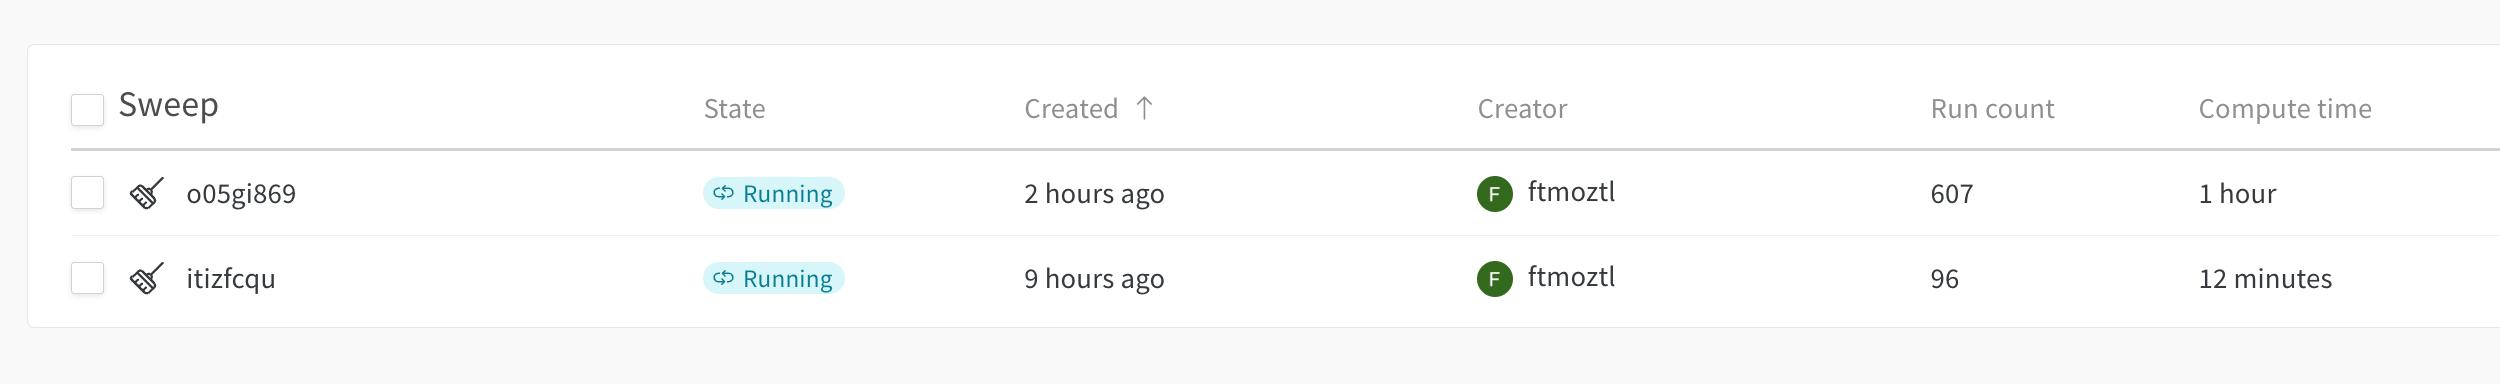

You can see the main screen which includes all runs inside the parameter tuning process. Each row represents a model with different parameters. You can track the models from this screen easily.

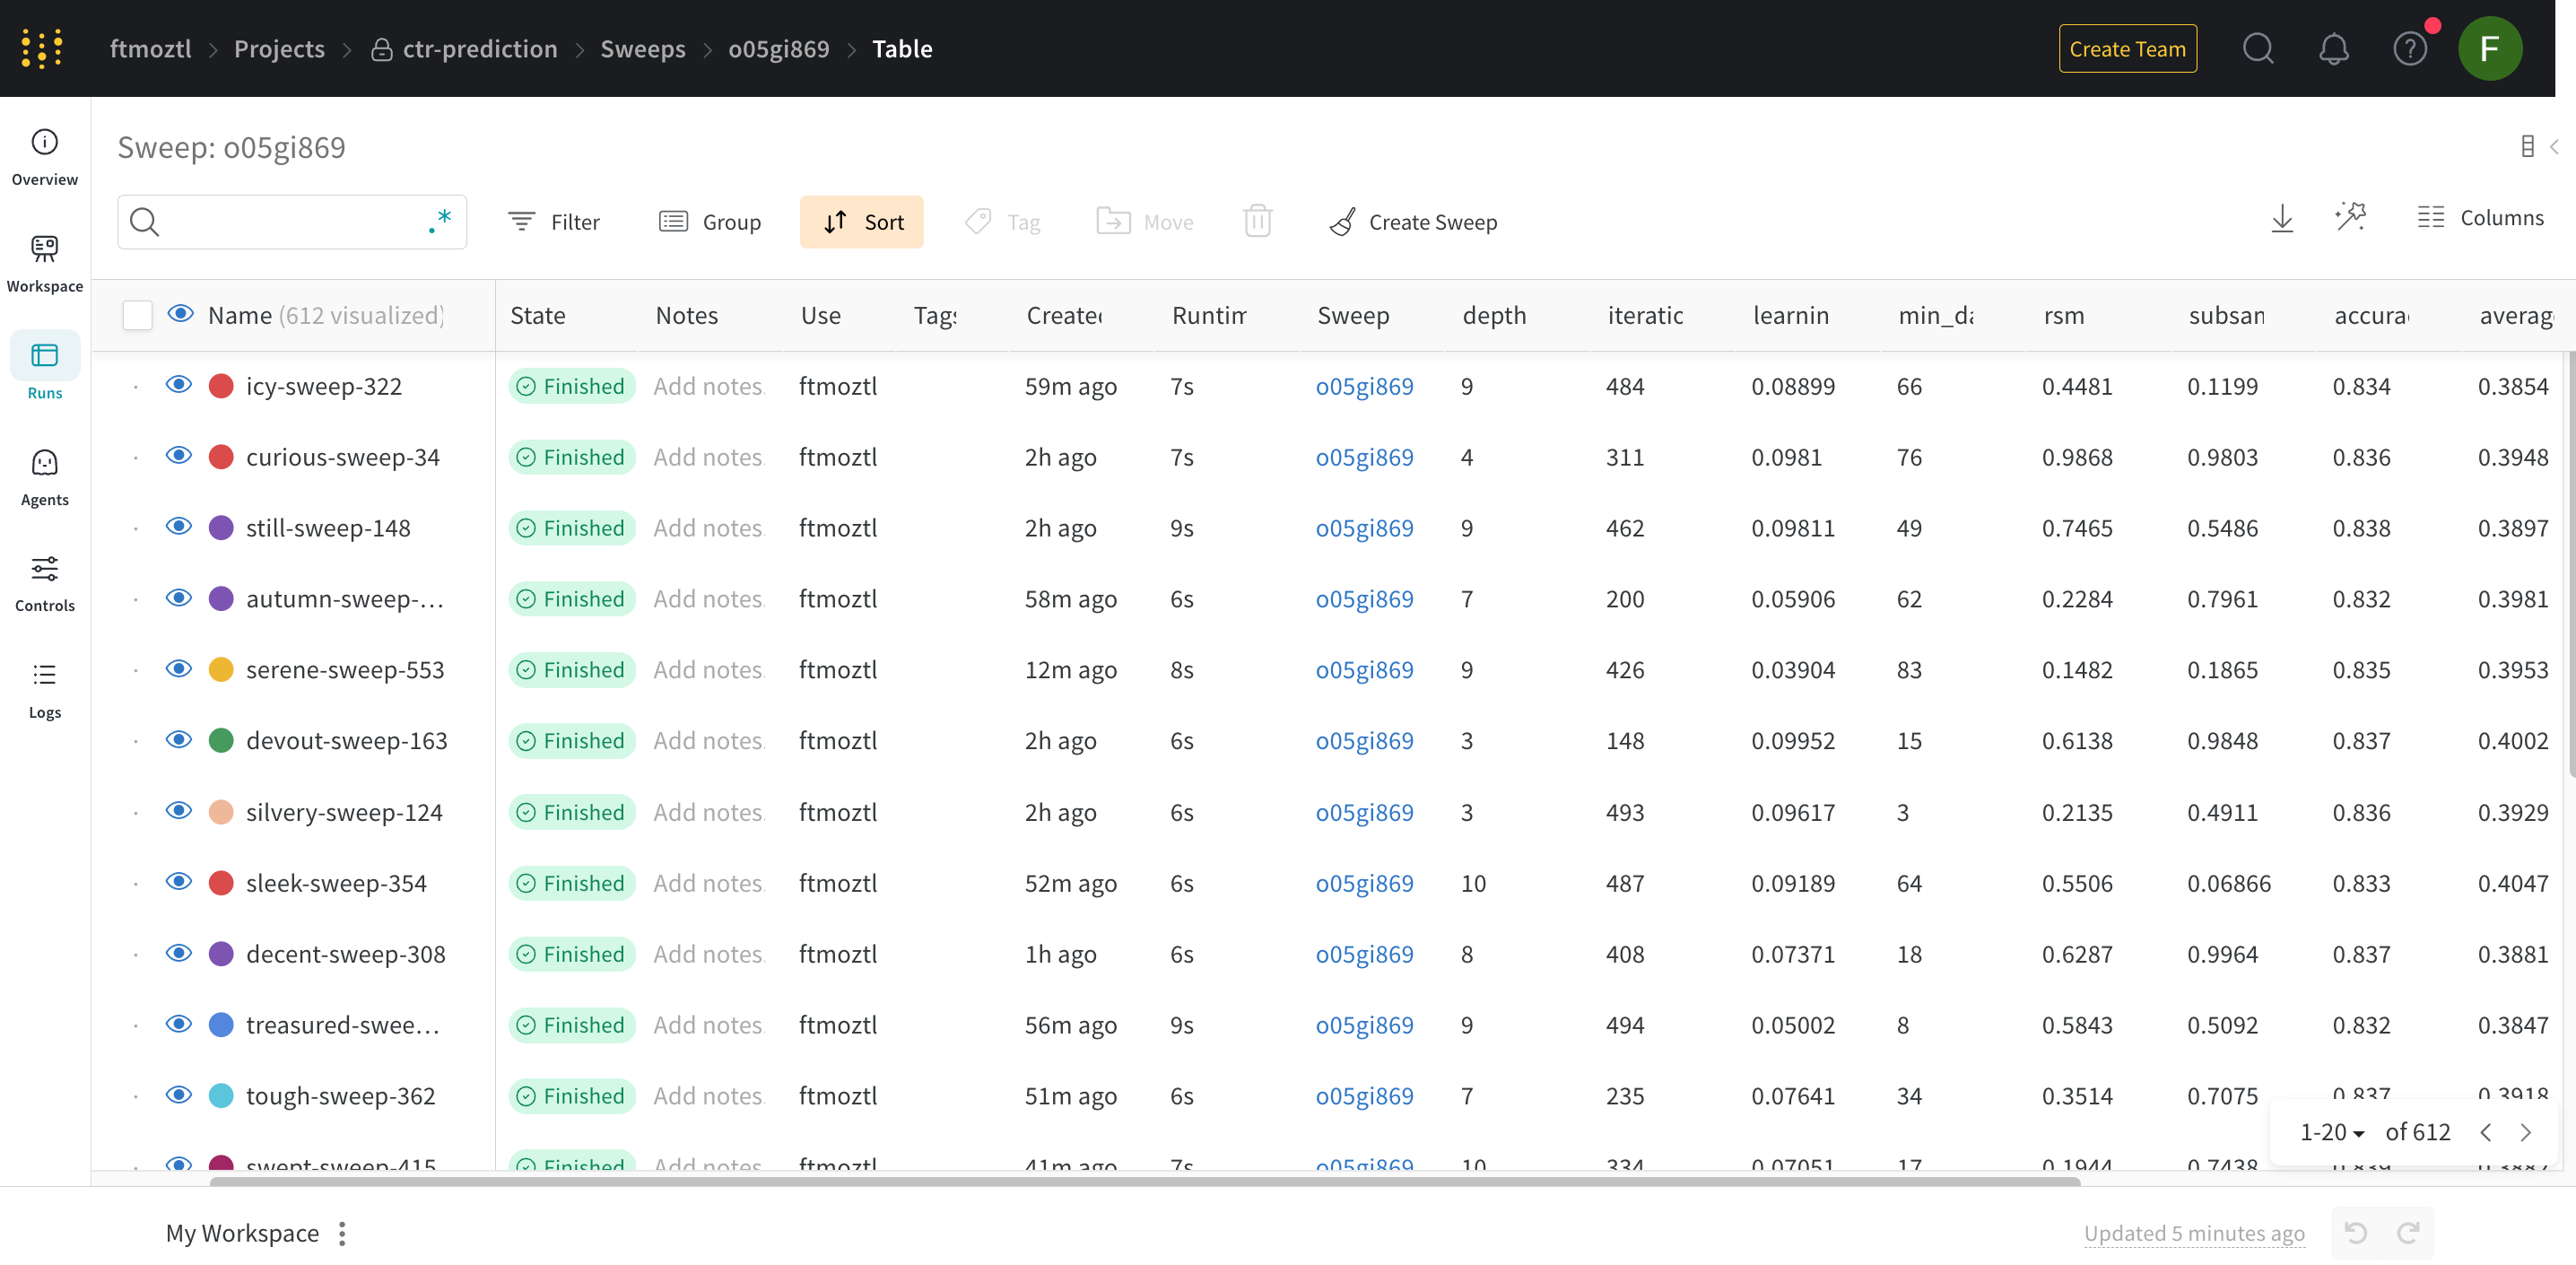

So,  you can check logged performance scores for each model on this screen, and you can filter and sort according to metrics. For example, the following screen is sorted by recall value in descending order. 

![sweep list.png](<attachment:sweep list.png>)
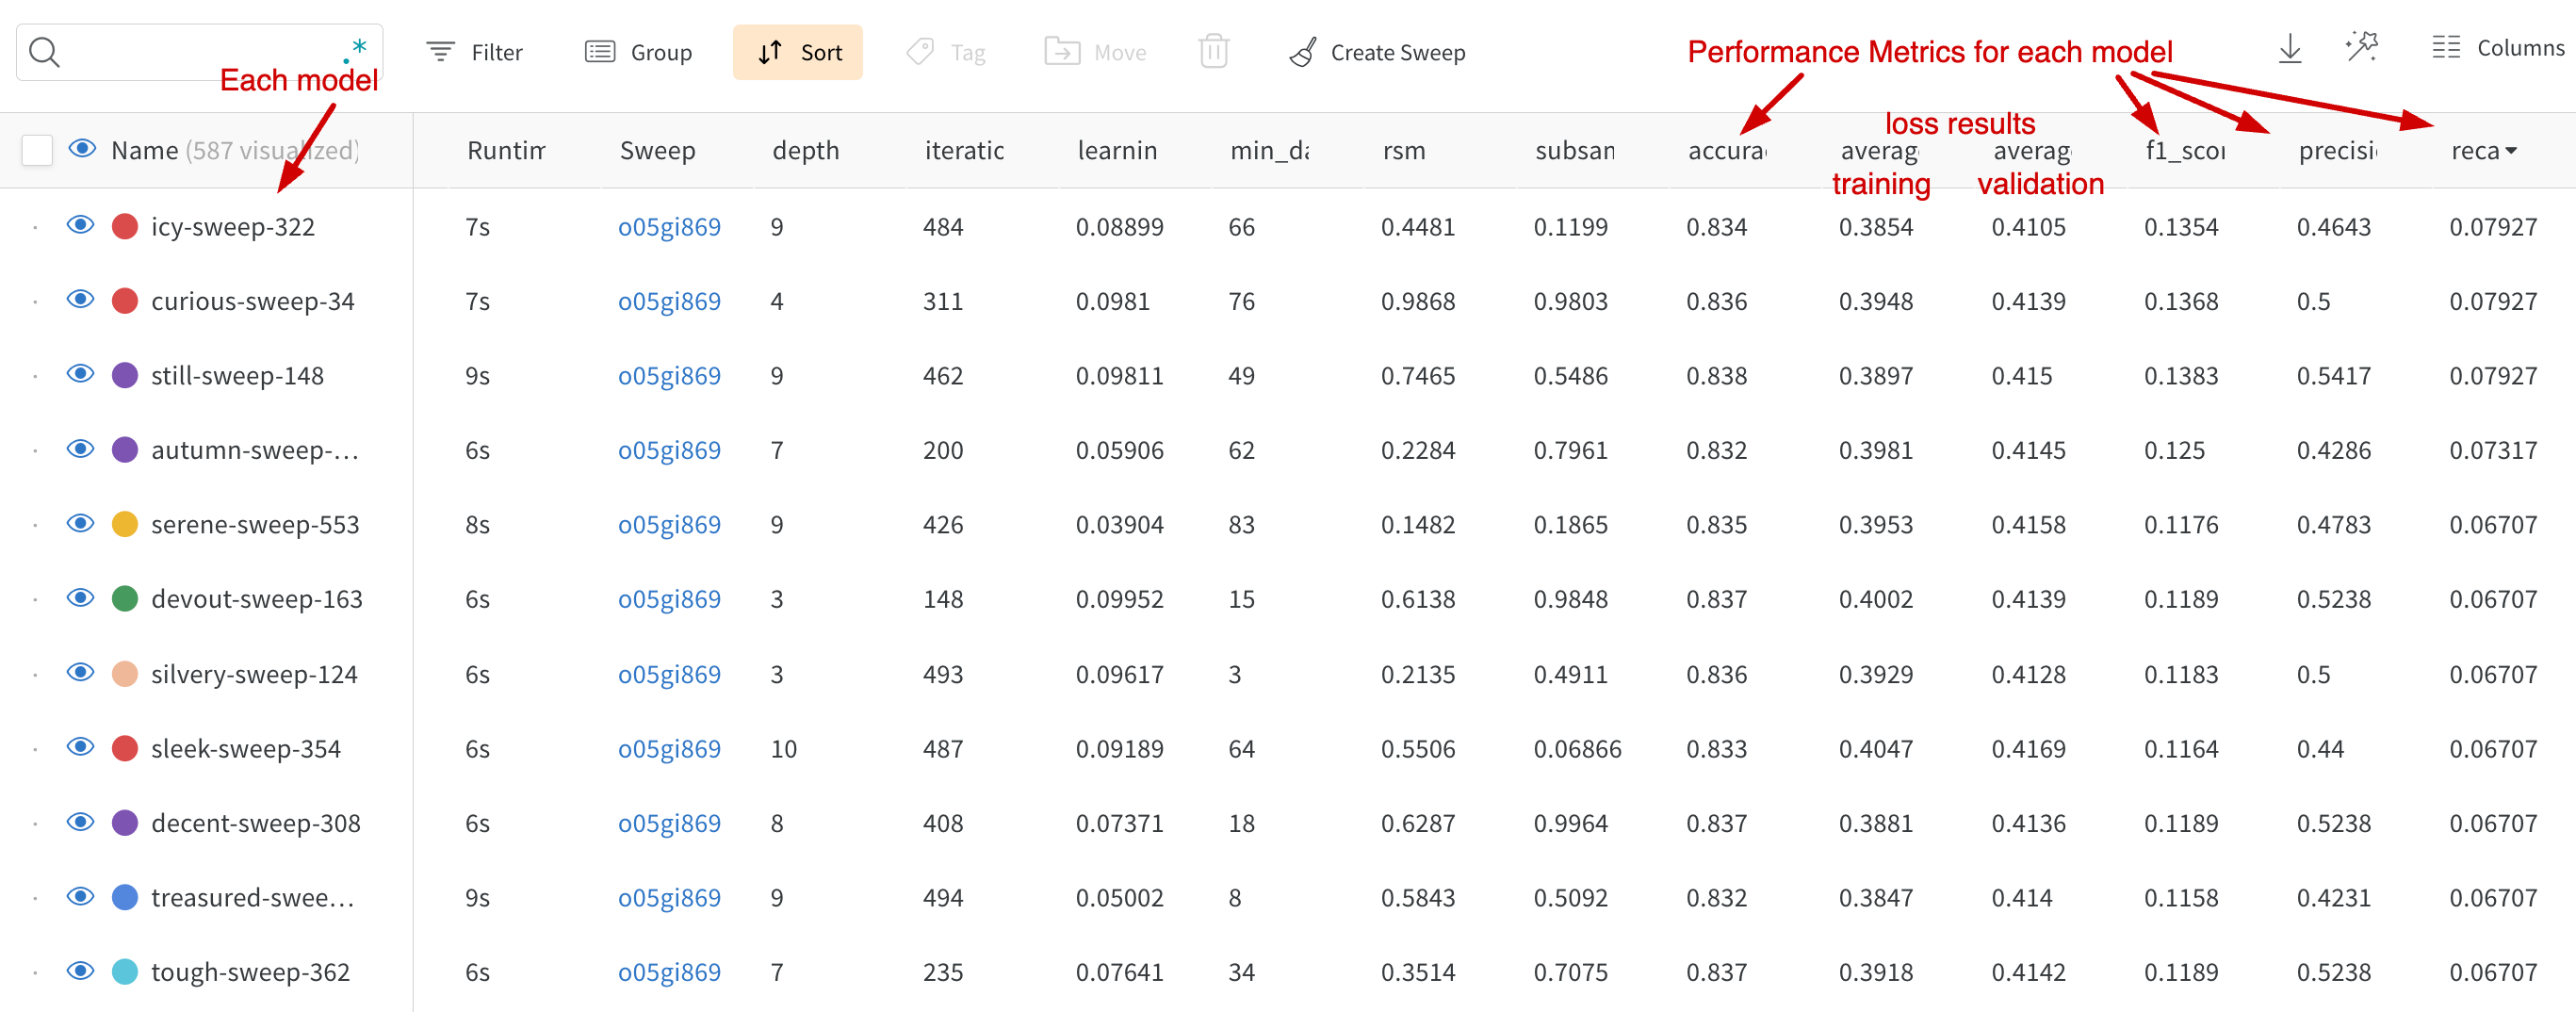

If you consider the recall, the icy-sweep-322 has the best recall score relative to the other runs. You can save this model in the tuning, or you can get the value of the parameter from this table and run the algorithm again with these parameters.

If you want to see the relationship between the parameters, W&B helps to visualize and create a report easily. For example, you can see the scatter plot validation loss, depth, and iteration. As mentioned above, minimum loss values were obtained from the high depth and iterations, which means that there can be the possibility of overfitting.

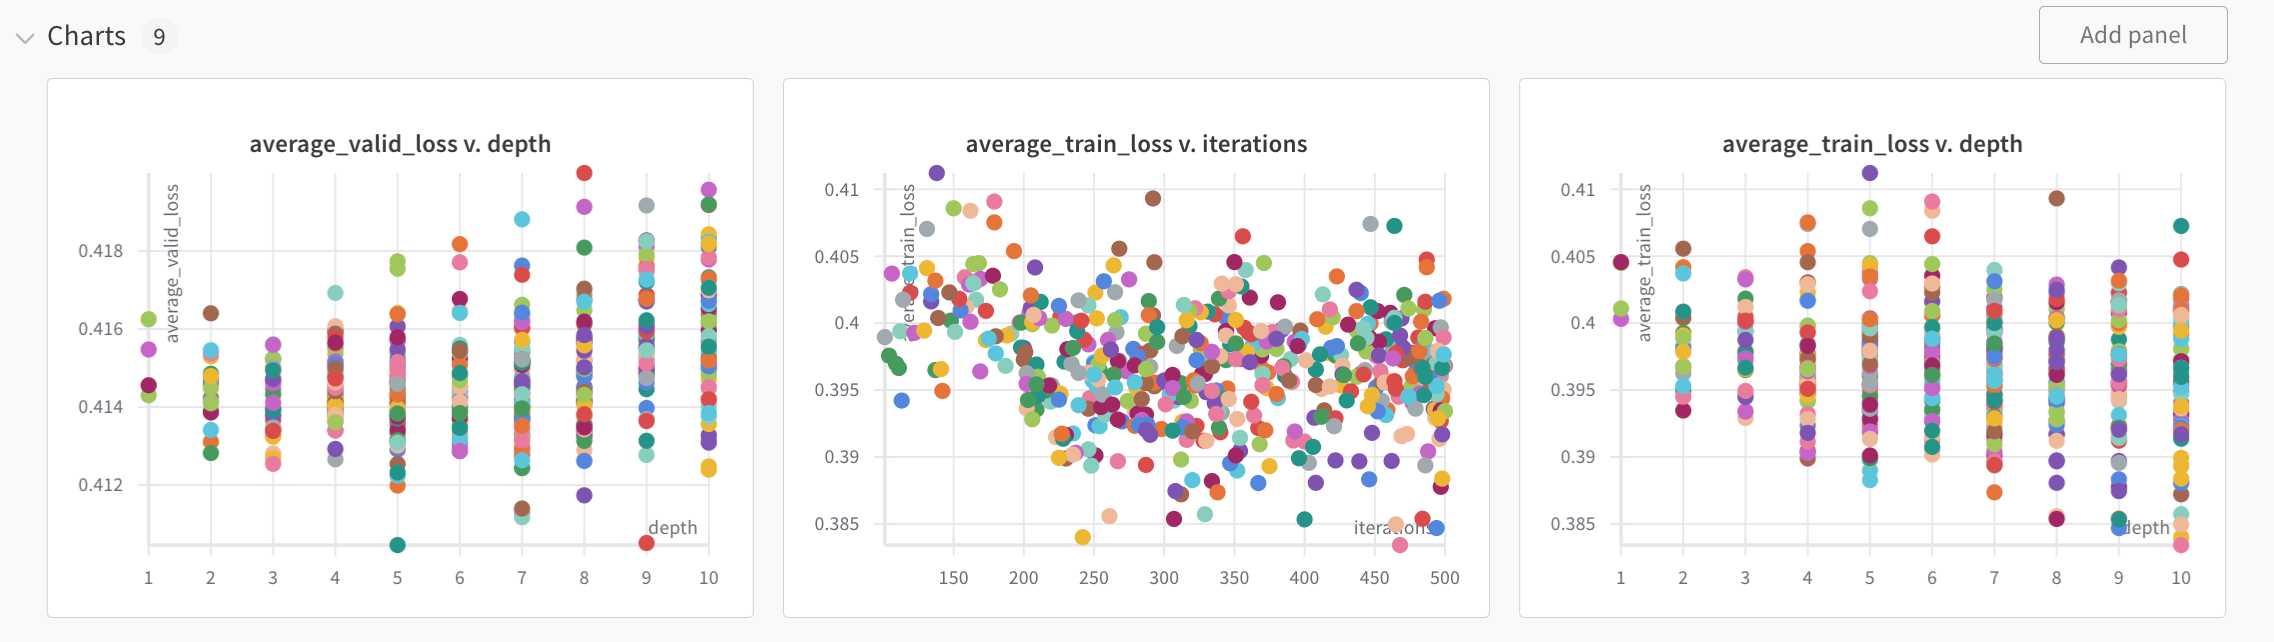

If you want to see the importance of the hyperparameters on the model performance, the W&B provides this info. You can find the table below, so the most important parameter which has the most effect on the model performance is 'subsample'. If the correlation is red, the parameter affects the performance in a reverse way. The second important factor is the learning rate (no surprise), so it should be tuned carefully.

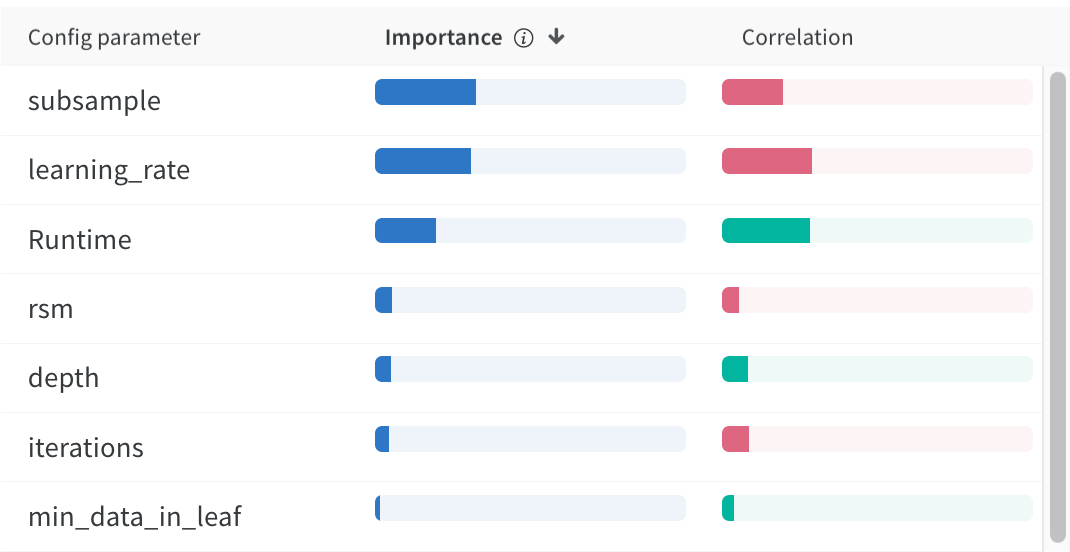

By creating a parallel coordinate graph, you can try to find the effect of the parameters on the loss or other results. You can find the example below, but it's hard to say such as high depth value decreases loss. But it's a good graph to see the obvious effects of parameters.

![parameter effect.png](<attachment:parameter effect.png>)
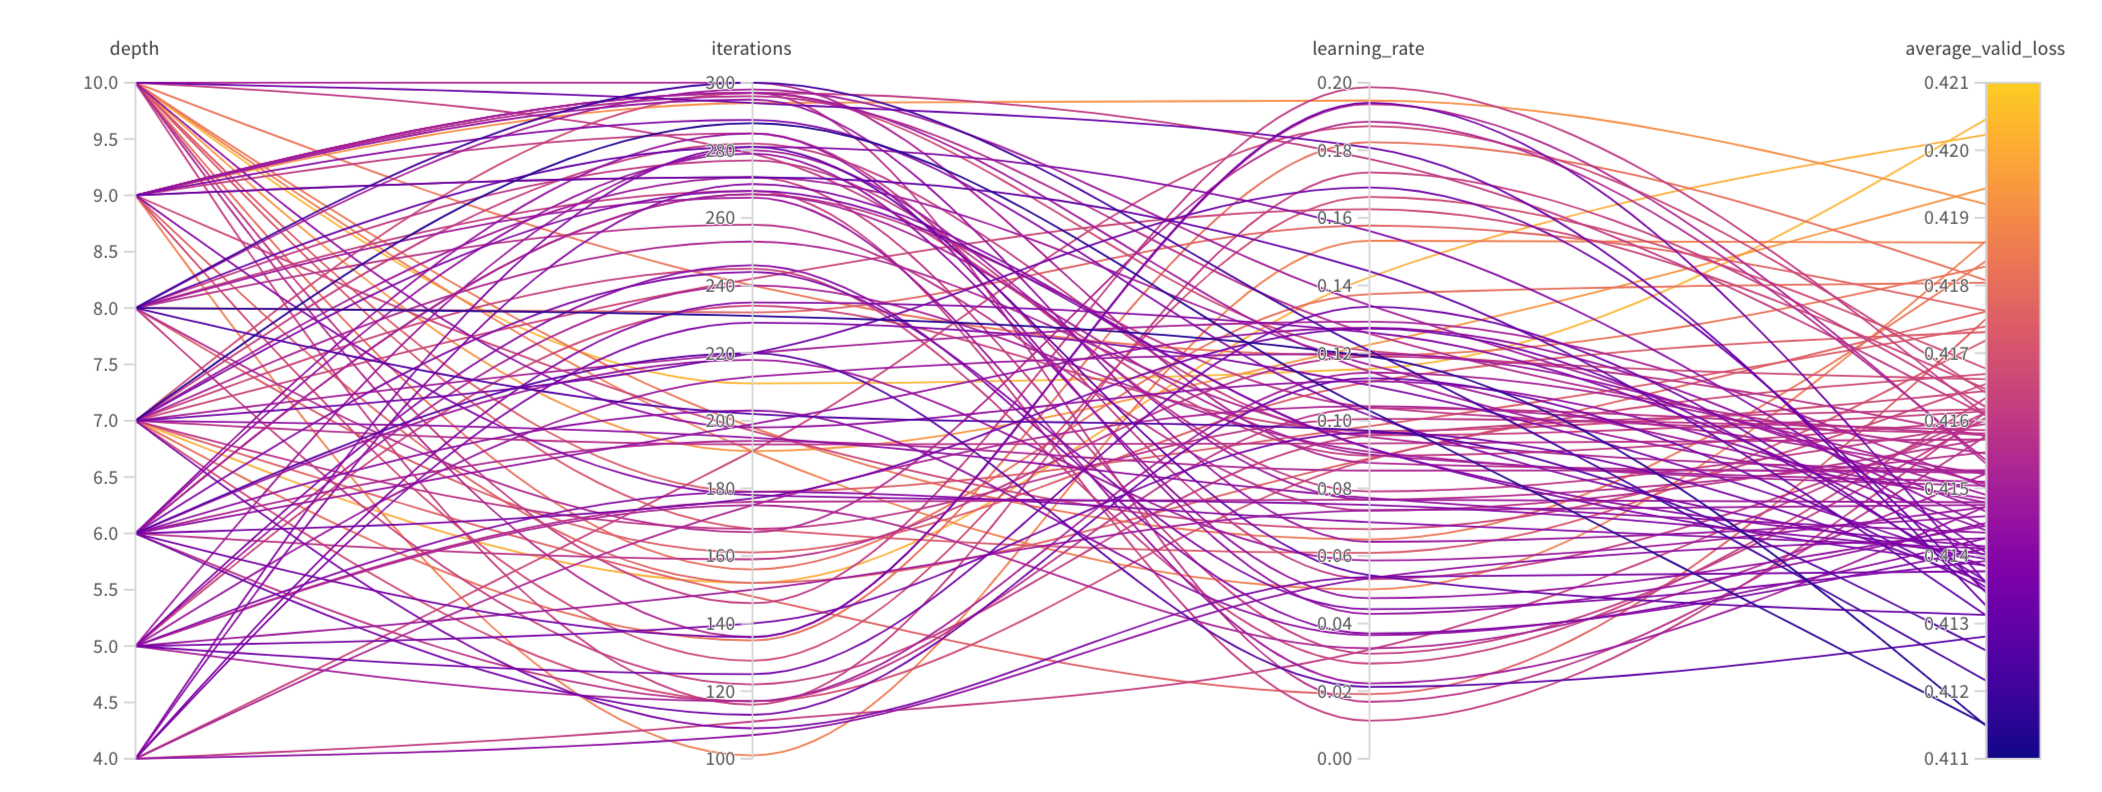

# OVERALL RESULTS

As a result of the training process, we couldn't get good recall results. The reason probably is using the imbalanced dataset. Also if we had used the whole dataset, we'd get more good results. But it's not the main purpose of this study, and computational power is the main restriction for this study. 

But if you want to improve the performance;
* You can use more data and a more balanced dataset. Or you can try techniques like oversampling the minority class, undersampling the majority class, or using synthetic data generation methods to balance the dataset. 
* You can continue fine-tuning the model's hyperparameters. Focus on optimizing for the best trade-off between precision and recall.
* As another choice, you can consider trying different algorithms or ensemble methods/algorithm.

**THANK YOU!**